# Sentiment classifier with LSTM

In this notebook, we will implement a simple sentiment classifier using an LSTM. Follow the notebook, complete the missing part, answer the questions and apply the asked modifications.



## Installation and import of necessary librairies

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from collections import defaultdict
from copy import deepcopy
import re
from typing import Callable, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from sklearn.utils import shuffle

Using the datasets library, we load the imdb dataset.

In [ ]:
dataset = load_dataset("imdb")

  0%|          | 0/3 [00:00<?, ?it/s]

## The dataset



Now that we have loaded our dataset, let's have a look on our data :

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

As we will only use the supervised learning here, we won't need the unsupervised part of our dataset.

In [ ]:
# We do not need the "unsupervised" split.
dataset.pop("unsupervised")

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

Now we have our final data, let's look at how our data looks like.

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [ ]:
dataset["train"][:2]

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

As we can see it in this text, there is a lot of punctuation and other little mistakes that we will have to take care of before using our data. Let's preprocess our data now !

## Pretreatment **(1 point)**

Code the `pretreatment` function which clean the input text. Look at the dataset and deduce which treatment is needed.

In [ ]:
%load utility_functions.py
import sys
sys.path.append("../tools/")
import utility_functions

def pretreatment(text: str) -> str:
    """Clean IMDB text entries.
    Args:
        text: an input string.
    Returns:
        The cleaned text.
    """
    text = utility_functions.preprocess_text(text)
    return text

In [ ]:
# This applies the pretreatment function to all
clean_dataset = dataset.map(lambda x: {"text": pretreatment(x["text"]), "label": x["label"]})

Let's see what the text now look like.

In [ ]:
clean_dataset["train"]["text"][:3]

['rented curiousyellow video store controversy surrounded first released 1967 also heard first seized us customs ever tried enter country therefore fan films considered controversial really see myselfbr br plot centered around young swedish drama student named lena wants learn everything life particular wants focus attentions making sort documentary average swede thought certain political issues vietnam war race issues united states asking politicians ordinary denizens stockholm opinions politics sex drama teacher classmates married menbr br kills curiousyellow 40 years ago considered pornographic really sex nudity scenes far even shot like cheaply made porno countrymen mind find shocking reality sex nudity major staple swedish cinema even ingmar bergman arguably answer good old boy john ford sex scenes filmsbr br commend filmmakers fact sex shown film shown artistic purposes rather shock people make money shown pornographic theaters america curiousyellow good film anyone wanting study

This is far better than the last time we printed our data ! 

Let's take a quick look at the labels. Notice that the labels are ordered in the training set starting by the negative reviews (0), followed by the positive ones (1). Training neural networks on this kind of configuration tends to considerably affect their performances. So the dataset will have to be shuffled.

In [ ]:
clean_dataset["train"]["label"][12490:12510]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
clean_dataset = clean_dataset.shuffle(seed=42)
clean_dataset["train"]["label"][12490:12510]

[1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1]

## Train/validation split **(1 point)**

In our example, we consider the test split as production data. Which means, we need to treat it as if we never see it during the training process. To experiment on the model, we need to split the training set into a training and validation set. See [here](https://huggingface.co/course/chapter5/3?fw=pt#creating-a-validation-set) on how to do so with the `Datasets` library.

Don't forget to **stratify** your split (we need to have the same proportion of class in both training and validation set).

In [ ]:
train_valid_split = clean_dataset["train"].train_test_split(train_size=0.8, seed=42, stratify_by_column="label")
clean_dataset["validation"] = train_valid_split["test"]
clean_dataset["train"] = train_valid_split["train"]

In [ ]:
clean_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

In [ ]:
# Check here that the dataset is stratified.

train_positive_review_rate = len(train_valid_split["train"].filter(lambda x : x["label"] == 1)) / len(train_valid_split["train"])
validation_positive_review_rate = len(train_valid_split["test"].filter(lambda x : x["label"] == 1)) / len(train_valid_split["test"])
print("Positive review rate for 'test' split:", train_positive_review_rate)
print("Positive review rate for 'validation' split:", train_positive_review_rate)

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

Positive review rate for 'test' split: 0.5
Positive review rate for 'validation' split: 0.5


## Categorical encoding of the vocabulary **(2 points)**

We can't feed word to a neural network. A usual solution is to turn words into categorical data by using one-hot encoding. To avoid an explosion in vocabulary size, we will only keep words which appear more than a certain amount of time.

The `Vocabulary` class below will do that for us.

In [ ]:
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"


class Vocabulary:
    """Vocabulary manager on a collection.
    """
    def __init__(self) -> None:
        """No parameters to provide.
        """
        # Index to word mapping.
        self.index2word = [PAD_TOKEN, UNK_TOKEN]
        # Word to index mapping.
        self.word2index = {value: key for key, value in enumerate(self.index2word)}
        # Word counter.
        self.word2count = defaultdict(int)

    def add_word(self, word: str) -> None:
        """Increments the count of a word to the vocabulary.
        Args:
            word: the word.
        """
        self.word2count[word] += 1
        if not word in self.word2index:
            self.word2index[word] = len(self.index2word)
            self.index2word.append(word)

    def add_text(self, text: str, separator: str =" ") -> None:
        """Add the words given in a text to our vocabulary.
        Args:
            text: a sequence of words separated by a given separator.
            separator: the separator used to split our text (default is " ").
        """
        for word in text.split(separator):
            self.add_word(word)

    def get_index(self, word: str) -> int:
        """Returns the index of a given word in our vocabulary.
        If the word is not in the vocabulary, returns the index for UNK_TOKEN.
        Args:
            word: a string.
        Returns:
            The corresponding index or the index for UNK_TOKEN.
        """
        return (
            self.word2index[word]
            if word in self.word2index
            else self.word2index[UNK_TOKEN]
        )

    def get_word(self, index: int) -> str:
        """Returns the word at a given index in our vocabulary.
        Args:
            index: the word position in our vocabulary.
        Returns:
            The word corresponding to the given index.
        """
        return self.index2word[index]

    def get_word_count(self, word: str) -> int:
        """Returns the number of occurences for a given word.
        Raise a 
        Args:
            The word.
        Returns:
            Its number of measured occurences.
        """
        return self.word2count[word]

    def get_vocabulary(self) -> List[str]:
        """Returns a copy of the whole vocabulary list.
        Returns:
            A list of words.
        """
        return deepcopy(self.index2word)

    def __len__(self) -> int:
        """len() function.
        Returns:
            The number of words in the vocabulary.
        """
        return len(self.index2word)

    def trim_vocabulary(self, min_occurences: int = 5) -> None:
        """Trim the vocabulary based on the number of occurrences of each words.
        Note that whole counts of deleted words are added to the UNK_TOKEN counts.
        Args:
            min_occurences: the minimum number of occurences for a word to be kept.
        """
        to_delete = {
            word for word, count in self.word2count.items() if count < min_occurences
        }
        new_word2count = defaultdict(int)
        for word, count in self.word2count.items():
            if word not in to_delete:
                new_word2count[word] = count
            else:
                new_word2count[UNK_TOKEN] += count
        new_index2word = [word for word in self.index2word if word not in to_delete]
        new_word2index = {word: index for index, word in enumerate(new_index2word)}

        self.word2count = new_word2count
        self.index2word = new_index2word
        self.word2index = new_word2index

**(1 point)** Get the vocabulary on both the training and validation set using the `Vocabulary` class. Remember, we don't use the test set here as we consider it as proxy production data. The trim it down as you see fit (around 20K words in the vocabulary is a good value).

In [ ]:
vocabulary = Vocabulary()

for text in clean_dataset["validation"]["text"]:
  vocabulary.add_text(text)

for text in clean_dataset["train"]["text"]:
  vocabulary.add_text(text)

vocabulary.trim_vocabulary(min_occurences=11)
len(vocabulary)

19919

**(1 point)** Fill the encoding and decoding functions. The encoding function takes a text as input and returns a list IDs corresponding to the index of each word in the vocabulary. The decoding function reverse the process, turning a list of IDs into a text. Make sure the encoding function returns a numpy array.

In [ ]:
# Encoding and decoding function

def encode_text(text: str) -> np.ndarray:
  return np.array([vocabulary.get_index(word) for word in text.split(" ")])

def decode_text(encoded_text: np.ndarray) -> str:
  return ' '.join([vocabulary.get_word(encoded_word) for encoded_word in encoded_text])

To make sure everything went well, we compare a text before and after encoding and then decoding it. You should see rare words / typos replaced by the `<UNK>` token.

In [ ]:
# Apply the encoding function to the entire dataset.
encoded_dataset = clean_dataset.map(lambda x: {"text": encode_text(x["text"]), "label": x["label"]})

  0%|          | 0/20000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/5000 [00:00<?, ?ex/s]

In [ ]:
clean_dataset["train"]["text"][0], decode_text(encoded_dataset["train"]["text"][0])

('excellent film extraordinary cast acting disappointed academy awards didnt get oscar best film best actress woopi goldberg certainly deserved case take look sure enjoy much',
 'excellent film extraordinary cast acting disappointed academy awards didnt get oscar best film best actress <UNK> goldberg certainly deserved case take look sure enjoy much')

As we can see it here, the clean text and the original text are the same ! So now we can do our batch preparation.

## Batch preparation **(1 point)**

To speed up learning, and take advantage of the GPU architecture, we provide data to the model by batches. Since all line in the same batch need to have the same length, we pad lines to the maximum length of each batch.

In [ ]:
def data_generator(X: np.ndarray, y: np.ndarray, batch_size: int = 32, pad_right: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """Generate randomly ordered batches of data+labels.
    Args:
        X: the input data.
        y: the corresponding labels.
        batch_size: the size of each batch [32].
        pad_right: if true, the padding is done on the right [False].
    """
    
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(len(y) / batch_size))
    
    for i in range(n_batches):
        
        end = min((i+1)*batch_size, len(y))
        
        X_batch = X[i*batch_size:end]
        y_batch = y[i*batch_size:end]

        # Padding to max ength size within the batch
        max_len = np.max([len(x) for x in X_batch])
        for j in range(len(X_batch)):
            x = X_batch[j]
            pad = [vocabulary.get_index(PAD_TOKEN)] * (max_len - len(x))
            X_batch[j] = x+pad if pad_right else pad+x

        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()

        # Yielding results, so every time the function is called, it starts again from here.
        yield X_batch, y_batch

Let's see what the batches look like.

In [ ]:
for inputs, labels in data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"]):
    print("inputs", inputs, "shape:", inputs.shape)
    print("labels", labels, "shape:", labels.shape)
    break

inputs tensor([[   0,    0,    0,  ..., 2389, 1116, 3666],
        [   0,    0,    0,  ...,  603,   23, 2433],
        [   0,    0,    0,  ..., 5546,  261, 1506],
        ...,
        [   0,    0,    0,  ..., 3224,   15,  493],
        [   0,    0,    0,  ..., 2573, 1095, 4060],
        [   0,    0,    0,  ...,   31, 5384,    1]]) shape: torch.Size([32, 307])
labels tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 0]) shape: torch.Size([32])


**(1 point)** Question: On which side should we pad the data for our use case and why?

For this question, mostly based on the values that we can see in the code here, we would say that we should pad our data on the right. Indeed, as we can see many 0 values on the left, those can induce our model in the wrong way and do some mistakes when doing predictions. On the other side, on the right, there are many different values so that should be the correct text so we must keep those values. 

## The model **(13 points)**

We use a simple RNN with a configurable number of layers.

In [ ]:
# Before starting, let's set up the device. A GPU if available, else the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Here is the simple RNN that we will use as our base :

In [ ]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

Note that we do not pass the output through a sigmoid function. This is because pyTorch implements some code optimization within the `BCEWithLogitsLoss` we'll see later.

In [ ]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizier: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    """
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)
    # Variables to keep the model with the lowest validation loss
    lowest_valid = 1.0
    lowest_valid_model = model

    for epoch in range(n_epochs):

        t0 = datetime.now()
        model.train()
        train_loss = []

        # Training loop.
        for inputs, labels in train_gen():
            # labels are of dimension (N,) we turn them into (N, 1).
            labels = labels.view(-1, 1).float()
            # Put them on the GPU.
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset the gradient.
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizier.step()

            train_loss.append(loss.item())  # .item() detach the value from GPU.

        train_losses[epoch] = np.mean(train_loss)

        model.eval()
        valid_loss = []
        # Evaluation loop.
        for inputs, labels in valid_gen():
            labels = labels.view(-1, 1).float()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss.append(loss.item())

        valid_losses[epoch] = np.mean(valid_loss)

        # Saving the model with the best validation loss
        if valid_losses[epoch] < lowest_valid:
            lowest_valid = valid_losses[epoch]
            lowest_valid_model = model

        print(f"Epoch: {epoch}, training loss: {train_losses[epoch]}, validation loss: {valid_losses[epoch]}, in {datetime.now() - t0}")

    return train_losses, valid_losses, lowest_valid_model

We setup the model, criterion (a binary cross entropy), and the optimizer (Adam).

Note that `BCEWithLogitsLoss` use a mathematical trick to incorporate the sigmoid function in its computation. This trick makes the learning process go slightly faster and is the reason why we didn't put a sigmoid in the forward function of the model.

In [ ]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

We get the 3 generators.

In [ ]:
train_gen = lambda: data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"])
valid_gen = lambda: data_generator(encoded_dataset["validation"]["text"], encoded_dataset["validation"]["label"])
test_gen = lambda: data_generator(encoded_dataset["test"]["text"], encoded_dataset["test"]["label"])

And train the model.

In [ ]:
train_losses, valid_losses, lowest_valid_model = train(model, criterion, optimizer, 20, train_gen, valid_gen)

Epoch: 0, training loss: 0.663873208618164, validation loss: 0.6870436527926451, in 0:00:07.721471
Epoch: 1, training loss: 0.6012850067138672, validation loss: 0.6091071765893584, in 0:00:06.548931
Epoch: 2, training loss: 0.6035898669242858, validation loss: 0.5679757097724137, in 0:00:06.541530
Epoch: 3, training loss: 0.5265206914663315, validation loss: 0.6344507792193419, in 0:00:06.454153
Epoch: 4, training loss: 0.539967953157425, validation loss: 0.5680342596617474, in 0:00:06.441843
Epoch: 5, training loss: 0.574283272576332, validation loss: 0.645793897710788, in 0:00:06.581422
Epoch: 6, training loss: 0.5463502820491791, validation loss: 0.5968789251366998, in 0:00:06.490833
Epoch: 7, training loss: 0.536319914484024, validation loss: 0.6167029994688217, in 0:00:06.463055
Epoch: 8, training loss: 0.48604421167373657, validation loss: 0.5489784817027438, in 0:00:06.379818
Epoch: 9, training loss: 0.5149672049999237, validation loss: 0.6193724914341215, in 0:00:06.539827
Epoc

We can look at the training and validation loss.

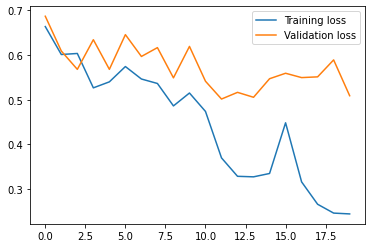

In [ ]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

For the assignment, code the following.
* **(2 points)** The model validation loss should go down and then up. It means the model starts overfitting after a certain number of iterations. Modify the `train` function so it returns the model found with the best validation loss.
* **(2 points)** Add an accuracy function and report the accuracy of the training and test set.
* **(3 points)** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
* **(2 point)** Implement a function which takes any text and return the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its probability (score out of a [sigmoid](https://pytorch.org/docs/stable/generated/torch.sigmoid.html)).
    * Don't forget to make the text go through the same pretreatment and encoding you used to train your model.
* **(3 points)** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * To combine the last output of both direction, you can concatenate, add, or max-pool them. Please document your choice.
* **(1 point)** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **(Bonus)** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

### 1 - **(2 points)** The model validation loss should go down and then up. It means the model starts overfitting after a certain number of iterations. Modify the train function so it returns the model found with the best validation loss.

For this question, you can see the modifications done in the train function by looking at the update of the "lowest_valid_model" value.

### 2 - **(2 points)** Add an accuracy function and report the accuracy of the training and test set.

For this question, we will implement many functions. The first ones are the flatten and accuracy functions.
Then we will implement the predict function to get the predictions of our model depending on the given dataset.

In [ ]:
# Function used to flatten our lists
def flatten(l):
  return [item for sublist in l for item in sublist]

# Function used to determine the accuracy of our model predictions
def accuracy(preds, target):
  differences = [0 if pred != label else 1 for (pred, label) in zip(preds, target)]
  return round(sum(differences)/len(differences), 2)

# Function used to get the prediction of our model based on the used_dataset variable
def predict(used_model, used_dataset):
  model.cuda()
  y_preds = []
  target = []
  last_input = None
  for inputs, labels in data_generator(used_dataset["text"], used_dataset["label"]):
    last_input = inputs
    inputs = inputs.cuda()
    y_pred = used_model(inputs)
    predicted_labels = [0 if i < 0 else 1 for i in flatten(y_pred.tolist())]
    target.append(labels.tolist())
    y_preds.append(predicted_labels)
  return flatten(y_preds), flatten(target)

Now let's have a look on the predictions of our model and his accuracy.

In [ ]:
y_preds_train, target_train = predict(lowest_valid_model, encoded_dataset["train"])
y_preds_test, target_test = predict(lowest_valid_model, encoded_dataset["test"])
y_preds_valid, target_valid = predict(lowest_valid_model, encoded_dataset["test"])

print("Predicted train:", y_preds_train)
print("Target train:   ", target_train)

print("\nPredicted test:", y_preds_test)
print("Target test:   ",   target_test)

print("\nPredicted validation:", y_preds_valid)
print("Target validation:   ",   target_valid)

Predicted train: [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1

With just a quick look, we can see some mistakes in the predictions of our model. But let's see his accuracy.

In [ ]:
print("Accuracy on train =", accuracy(y_preds_train, target_train))
print("Accuracy on test  =", accuracy(y_preds_test, target_test))
print("Accuracy on validation  =", accuracy(y_preds_valid, target_valid))

Accuracy on train = 0.92
Accuracy on test  = 0.78
Accuracy on validation  = 0.78


This is quite good for a so simple model and just a little bit of training !

### 3 - **(3 points)** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.

Now let's use a LSTM instead of the RNN and see what results we can have.

In [ ]:
class LSTM(nn.Module):

    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # LSTM layer process the vector sequences 
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True,
        )
        self.fc = nn.Linear(hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        # Initialize the needed values for the LSTM
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.

        # Using our LSTM layer
        out, _ = self.lstm(out, (h0, c0))

        # Getting the last value only.
        out = out[:, -1, :]
        # Linear projection.
        out = self.fc(out)

        return out

In [ ]:
lstm_model = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)

Now that we have our model, let's train it with an Adam optimizer and see his results.

In [ ]:
lstm_criterion = torch.nn.BCEWithLogitsLoss().to(device)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters())

train_losses, valid_losses, lowest_valid_lstm = train(lstm_model, lstm_criterion, lstm_optimizer, 20, train_gen, valid_gen)

Epoch: 0, training loss: 0.6407918085098266, validation loss: 0.5991688275792796, in 0:00:06.502939
Epoch: 1, training loss: 0.48649274685382843, validation loss: 0.622741021643019, in 0:00:06.588957
Epoch: 2, training loss: 0.4654487617254257, validation loss: 0.6793144516124847, in 0:00:06.314365
Epoch: 3, training loss: 0.5489494875431061, validation loss: 0.7099532052210182, in 0:00:06.349970
Epoch: 4, training loss: 0.6497613736152649, validation loss: 0.8009957752789661, in 0:00:06.394528
Epoch: 5, training loss: 0.768850738286972, validation loss: 1.0545929571625534, in 0:00:06.372447
Epoch: 6, training loss: 0.7963560821533203, validation loss: 1.1169904544474973, in 0:00:06.568877
Epoch: 7, training loss: 0.8186856751918793, validation loss: 0.7938212913692377, in 0:00:06.373946
Epoch: 8, training loss: 0.8848808732986451, validation loss: 1.2608844960571095, in 0:00:06.467781
Epoch: 9, training loss: 0.8899728514194488, validation loss: 0.9604694784446887, in 0:00:06.367656
E

By using the functions that we implemented in the last question, let's see his accuracy.

In [ ]:
y_preds_train, target_train = predict(lowest_valid_lstm, encoded_dataset["train"])
y_preds_test, target_test = predict(lowest_valid_lstm, encoded_dataset["test"])

print("Predicted train:", y_preds_train)
print("Target train:   ", target_train)

print("\nPredicted test:", y_preds_test)
print("Target test:   ",   target_test)

Predicted train: [0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0

In [ ]:
print("Accuracy on train =", accuracy(y_preds_train, target_train))
print("Accuracy on test  =", accuracy(y_preds_test, target_test))

Accuracy on train = 0.67
Accuracy on test  = 0.6


As we can see it here, with our data, the LSTM has an accuracy that is less precise than the RNN.

### 4 - **(2 point)** Implement a function which takes any text and return the model's prediction.
* The function should have a string as input and return a class (0 or 1) and its probability (score out of a [sigmoid](https://pytorch.org/docs/stable/generated/torch.sigmoid.html)).
* Don't forget to make the text go through the same pretreatment and encoding you used to train your model.

In [ ]:
def predict_single_string(used_model, input):
  used_model.cuda()
  encoded_input = encode_text(pretreatment(input))
  input_to_tensor = torch.tensor([encoded_input]).cuda()
  predicted_label_raw = used_model(input_to_tensor)
  predicted_probability = torch.sigmoid(predicted_label_raw).item()
  predicted_label = 0 if predicted_label_raw.item() < 0 else 1
  return predicted_label, predicted_probability

Now that our function is implemented, let's test it !

In [ ]:
test_str = 'A movie with a really interesting idea and with menacing aliens as enemies it was fun to watch. It is very interesting to see.'

pred_label, pred_proba = predict_single_string(lowest_valid_lstm, test_str)

print('Predicted label:', pred_label)
print('Label probability:', pred_proba)

A movie with a really interesting idea and with menacing aliens as enemies it was fun to watch It is very interesting to see
Predicted label: 1
Label probability: 0.6497236490249634


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  after removing the cwd from sys.path.


### 5 - **(3 points)** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
  
  * To combine the last output of both direction, you can concatenate, add, or max-pool them. Please document your choice.

In [ ]:
class BiLSTM(nn.Module):

    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # LSTM layer process the vector sequences 
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            # Adding the bidirectional parameter to True
            bidirectional=True,
            batch_first = True,
        )
        # Layer used if we want to MaxPool our data 
        self.maxpool = nn.MaxPool1d(32) 
        self.fc = nn.Linear(hidden_size * 2, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        # Initialize the needed values for the LSTM
        h0 = torch.zeros(self.n_layers * 2, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers * 2, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, (hn, cn) = self.lstm(out, (h0, c0))
        
        x = hn                       # => [num_layers * num_directions, batch_size, hidden_size]
        x = x.permute(1, 0, 2)       # => [batch_size, num_layers * num_directions, hidden_size]

        # Concatening the results
        x = x.contiguous().view(X.size(0), self.n_layers * 2 * self.hidden_size)   
        # => [batch_size, num_layers * num_directions * hidden_size]
        x = self.fc(x)

        return x

Here, we choose to concatenate to keep the maximum of informations as possible for our model. This is also because we tried the MaxPool and the results were not that good with our model and our data.

Now let's train and see the results of our BiLSTM model : 

In [ ]:
bilstm_model = BiLSTM(len(vocabulary), 32, 64, 1, 1).to(device)

bilstm_criterion = torch.nn.BCEWithLogitsLoss().to(device)
bilstm_optimizer = torch.optim.Adam(bilstm_model.parameters())

train_losses, valid_losses, lowest_valid_bilstm = train(bilstm_model, bilstm_criterion, bilstm_optimizer, 20, train_gen, valid_gen)

Epoch: 0, training loss: 0.6408493643760681, validation loss: 0.7426357506566746, in 0:00:05.206084
Epoch: 1, training loss: 0.47599228863716125, validation loss: 0.6600436554972533, in 0:00:05.023340
Epoch: 2, training loss: 0.4018661061286926, validation loss: 0.6364949162408804, in 0:00:05.088519
Epoch: 3, training loss: 0.4036188056588173, validation loss: 0.6640803215989641, in 0:00:05.162716
Epoch: 4, training loss: 0.43844641383886335, validation loss: 0.6821327422075211, in 0:00:05.083825
Epoch: 5, training loss: 0.46496645045280455, validation loss: 0.7016899728091659, in 0:00:05.088137
Epoch: 6, training loss: 0.48797310309410097, validation loss: 0.7151333963035778, in 0:00:05.069091
Epoch: 7, training loss: 0.515221972990036, validation loss: 0.7563297475219533, in 0:00:05.160353
Epoch: 8, training loss: 0.5475324342489243, validation loss: 0.7389437368341313, in 0:00:05.063221
Epoch: 9, training loss: 0.5707064799785614, validation loss: 0.829103463204803, in 0:00:05.05253

In [ ]:
y_preds_train, target_train = predict(lowest_valid_bilstm, encoded_dataset["train"])
y_preds_test, target_test = predict(lowest_valid_bilstm, encoded_dataset["test"])

print("Predicted train:", y_preds_train)
print("Target train:   ", target_train)

print("\nPredicted test:", y_preds_test)
print("Target test:   ",   target_test)

Predicted train: [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1

In [ ]:
print("Accuracy on train =", accuracy(y_preds_train, target_train))
print("Accuracy on test  =", accuracy(y_preds_test, target_test))

Accuracy on train = 0.69
Accuracy on test  = 0.61


As we can see it here, this is clearly not the best model with our data to have the higher accuracy as possible.

### 6 - **(1 point)** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.


The model wich has the best accuracy is the RNN. Let's see some classification errors.



In [ ]:
classification_errors = [(decode_text(encoded_dataset["test"]["text"][i]), y_preds_test[i], target_test[i]) for i in range(100) if y_preds_test[i] != target_test[i]]

for text, pred, label in classification_errors[:2]:
  print("Prediction:", pred, "| label:", label, "| text:", text, "\n")

Prediction: 1 | label: 0 | text: latest entry long series films french agent <UNK> <UNK> french answer james bond series launched early 1950s spawned least eight films none ever released us <UNK> spies breezy little comedy <UNK> taken seriously protagonist finds middle spy chase egypt <UNK> stand egypt find long lost friend follows standard james <UNK> <UNK> kind antics although man something overt <UNK> treated pure farce said dont take seriously although bit rough language cartoon violence basically okay older kids ages 12 previously stated subject line sit <UNK> popcorn enjoy 

Prediction: 1 | label: 0 | text: movie frustrating everything seemed energetic totally prepared good time least thought id able stand wrong first weird <UNK> like watching americas funniest home videos damn parents hated much stereotypical latino family need speak person responsible need talk little girl always hanging someone hated mention final scene transcends must say gloriously bad full badness movie cra

#### Classification errors

As the errors that are displayed in the code just before, we kept the two texts that were not correctly classified here to have a better understanding of our analysis.

Prediction: 0 | label: 1 | text: latest entry long series films french agent <UNK> <UNK> french answer james bond series launched early 1950s spawned least eight films none ever released us <UNK> spies breezy little comedy <UNK> taken seriously protagonist finds middle spy chase egypt <UNK> stand egypt find long lost friend follows standard james <UNK> <UNK> kind antics although man something overt <UNK> treated pure farce said dont take seriously although bit rough language cartoon violence basically okay older kids ages 12 previously stated subject line sit <UNK> popcorn enjoy 

Prediction: 1 | label: 0 | text: dont pay attention rave reviews film worst van damme film one worst sort ever seen would appeal somebody depth whatever requires nothing gunfire explosions entertainedbr br seeing directed peter <UNK> made realise peter talent director good filming explosions like however movies need elements well example story one didnt one might explain awfulness mr <UNK> recent films hardly better one reallybr br one cant help wondering people ever put behind camera 

The first classification error is a negative review classified as a positive one and the second classificatioin error is the opposite.

In the first review, there are a lot of word with a neutral connotation and there are some words with a positive connotation (such as friend, kind, enjoy, commedy) that may have confused the model.

As for the second review, there is 3 words with negative connotation (worst x2, awfulness) and 3 words with a positive connotation (talent, good, better) so these positive words might have more impact on the prediction than the negative ones, caussing a classification error.